lstm2

과정 요약:<br> 
feature: season, day of week, week number, sales <br> 
feature engineering: 이상점 제거+ normalize+ denormalize

결과요약: RMSE: 0.24234837293624878 

상세과정:
주중(1)/주말(2) + 겨울(1)봄(2)여름(3)가을(4) // 
이미 lstm이라는 것이 sequence 개념이 있으므로 시간축(1~397)를 feature로 설정하는 것은 의미가 없을 듯 하여 LSTM 시도2에서는 제외함

추가의견) 개인적으로 이상점을 제거한 후 normalize를 하면 rmse가 커질 수 밖에 없다고 생각함. 다음시도(lstm3)은 이상점을 제거하지 않고 normalize를 하고, lstm4에서는 이상점을 제거하고 normalize를 하지 않는 것을 시도하겠다.

추가의견2) 처음에는 denormalize과정 없이 rmse를 구했는데, 이것보다는 denormalize를 한 후 rmse를 구하여 모델간 비교를 하는 것이 더 적절한 것 같다. normalize는 어디까지나 변환이니 항상 변환을 할때는 역변환을 하여 원본 데이터 형태m로 생각하는 것이 덜 헷갈리고, 결과값에 대한 더욱 직관적인 이해가 가능할 것 같다. 그리고, 여러 형태의 data transformation이 있는데 normalize 가장 마지막 단계의 data transformation인 것 같다. 다른 로그나 루트 변환을 한 후 normalization을 하고, 그리고 예측값이 모델을 통해 생성되면 바로 denormalize하고...예측(뉴럴) 모델의 input직전과 output직후.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime   

set seednumber(7 or 77)

In [2]:
tf.set_random_seed(77)

# 1. DATA 준비

In [3]:
columns=['date','sales']

txs=pd.read_table('./lstmData/lstmPrac2.csv', sep=',',header=None,names=columns )
txs.info()
txs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
date     397 non-null object
sales    397 non-null int64
dtypes: int64(1), object(1)
memory usage: 6.3+ KB


,date,sales
0,2016-01-01,34
1,2016-01-02,41
2,2016-01-03,54
3,2016-01-04,41
4,2016-01-05,35


In [4]:
sales=list(txs['sales'])

## 1.1 기본 feature

'ds-y'의 ds로부터 api로 얻을 수 있는 값

year, day of week, month, week number를 기본 feature로 설정

In [5]:
year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year  
day_of_week = lambda x: datetime.strptime(x, "%Y-%m-%d" ).weekday()
month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
# please read docs on how week numbers are calculate
week_number = lambda x: datetime.strptime(x, "%Y-%m-%d" ).strftime('%V')

In [6]:
txs['year'] = txs['date'].map(year)
txs['month']=txs['date'].map(month)
txs['week_number']=txs['date'].map(week_number)
txs['day_of_week']=txs['date'].map(day_of_week)

## 1.2 추가 feature

'ds-y'의 ds로부터 api로 얻을 수 없는 값: 본 feature를 가공한 feature + ds와 무관한 feature

In [7]:
seasons = [0,0,1,1,1,2,2,2,3,3,3,0] #dec - feb is winter, then spring, summer, fall etc
season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d" ).month-1)]

In [8]:
txs['season']=txs['date'].map(season)
txs

,date,sales,year,month,week_number,day_of_week,season
0,2016-01-01,34,2016,1,53,4,0
1,2016-01-02,41,2016,1,53,5,0
2,2016-01-03,54,2016,1,53,6,0
3,2016-01-04,41,2016,1,01,0,0
4,2016-01-05,35,2016,1,01,1,0
5,2016-01-06,44,2016,1,01,2,0
6,2016-01-07,50,2016,1,01,3,0
7,2016-01-08,42,2016,1,01,4,0
8,2016-01-09,42,2016,1,01,5,0
9,2016-01-10,66,2016,1,01,6,0


pandas를 통해 구한 각 feature는 list()로 우리의 기준type인 list로 변경이 가능

## 1.3 합친 후 normalize하여 최종 data 생성: XY

In [9]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

In [10]:
XY=np.array(tempxy).transpose().astype(np.float)

In [11]:
XY

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

## 1.3 추가 가공

### 1.3.1 y의 추가 가공

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음

In [12]:
originalSales=sales

이상점 제거, bucketization 을 하여 새로운 열을 생성하는 방향으로

#### 이상점 제거

이상점 제거를 위해 평균과 표준편차를 구한다. 이상점의 기준은 일단 평균+-2*sd로 설정

### 1.3.2 x의 추가 가공

## 1.4 합친 후 normalize하여 최종 data 생성: XY

In [13]:
tempxy=[list(txs['season']),list(txs['day_of_week']),list(txs['week_number']),sales]

In [14]:
xy=np.array(tempxy).transpose().astype(np.float)

In [15]:
xy

array([[  0.,   4.,  53.,  34.],
       [  0.,   5.,  53.,  41.],
       [  0.,   6.,  53.,  54.],
       ..., 
       [  0.,   6.,   4.,   0.],
       [  0.,   0.,   5.,   5.],
       [  0.,   1.,   5.,  31.]])

#### Normalization

In [16]:
def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

마지막rmse를 계산할 때 원본 데이터를 복원하기 위해 저장해놓음

In [17]:
originalSales=sales

Normalization이 필요한 열을 normalize시킴(현재는 sales에 해당하는 마지막 열만 normalize)

In [18]:
xy[:,-1]=minMaxNormalizer(xy[:,-1])

다른 열 ex) XY[:,-3]=minMaxNormalizer(XY[:,-3])

In [19]:
xy

array([[  0.00000000e+00,   4.00000000e+00,   5.30000000e+01,
          5.96491228e-02],
       [  0.00000000e+00,   5.00000000e+00,   5.30000000e+01,
          7.19298245e-02],
       [  0.00000000e+00,   6.00000000e+00,   5.30000000e+01,
          9.47368421e-02],
       ..., 
       [  0.00000000e+00,   6.00000000e+00,   4.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   5.00000000e+00,
          8.77192982e-03],
       [  0.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          5.43859649e-02]])

In [20]:
xy[:,-1]

array([ 0.05964912,  0.07192982,  0.09473684,  0.07192982,  0.06140351,
        0.07719298,  0.0877193 ,  0.07368421,  0.07368421,  0.11578947,
        0.0877193 ,  0.09649123,  0.09824561,  0.09298246,  0.07719298,
        0.09473684,  0.09473684,  0.0877193 ,  0.07017544,  0.08596491,
        0.04912281,  0.12631579,  0.1245614 ,  0.09298246,  0.0754386 ,
        0.06666667,  0.09649123,  0.08596491,  0.0754386 ,  0.08596491,
        0.08596491,  0.07719298,  0.06842105,  0.09122807,  0.07894737,
        0.05789474,  0.0754386 ,  0.07017544,  0.08070175,  0.08596491,
        0.0877193 ,  0.06491228,  0.06491228,  0.07894737,  0.08421053,
        0.08421053,  0.06666667,  0.10526316,  0.05438596,  0.06140351,
        0.09298246,  0.12280702,  0.10877193,  0.08421053,  0.08947368,
        0.08596491,  0.06666667,  0.05614035,  0.06842105,  0.06140351,
        0.05263158,  0.06315789,  0.05438596,  0.05438596,  0.07719298,
        0.07192982,  0.07192982,  0.07894737,  0.08070175,  0.07

#### Denormalization

예측모델을 통해 얻은 sales결과를 denormalize시켜 기존 단위로 변환

In [21]:
def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier 

이 함수를 마지막 rmse구하기 전에 호출

# 2. MODEL 설계

## 2.1 사용 model 정의: RNN LSTM

## 2.2 해당 model의 train parameters 설정

In [22]:
#data_dim은 y값 도출을 위한 feature 가지수(독립변수 가지수 +1(y포함))
data_dim=4

#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=7

#output_dim(=forecastDays)만큼의 다음날 y_data를 예측
forecastDays=1
output_dim=forecastDays

#hidden_dim은 정말 임의로 설정
hidden_dim=10

#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01

#iterations는 반복 횟수
iterations=1000

## 2.3 사용 model, train parameter에 맞추어 dataset(XY) 변환: dataX, dataY

In [23]:
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length):
    _x=x[i:i+seq_length]
    _y=y[i+seq_length]
    #     _y=Y[i+seq_length:i+seq_length+forecastDays]
    print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)

[[  0.           4.          53.           0.05964912]
 [  0.           5.          53.           0.07192982]
 [  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.           1.           0.07719298]
 [  0.           3.           1.           0.0877193 ]] -> [ 0.07368421]
[[  0.           5.          53.           0.07192982]
 [  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.           1.           0.07719298]
 [  0.           3.           1.           0.0877193 ]
 [  0.           4.           1.           0.07368421]] -> [ 0.07368421]
[[  0.           6.          53.           0.09473684]
 [  0.           0.           1.           0.07192982]
 [  0.           1.           1.           0.06140351]
 [  0.           2.          

 [ 0.          6.          5.          0.07017544]] -> [ 0.08070175]
[[ 0.          1.          5.          0.06842105]
 [ 0.          2.          5.          0.09122807]
 [ 0.          3.          5.          0.07894737]
 [ 0.          4.          5.          0.05789474]
 [ 0.          5.          5.          0.0754386 ]
 [ 0.          6.          5.          0.07017544]
 [ 0.          0.          6.          0.08070175]] -> [ 0.08596491]
[[ 0.          2.          5.          0.09122807]
 [ 0.          3.          5.          0.07894737]
 [ 0.          4.          5.          0.05789474]
 [ 0.          5.          5.          0.0754386 ]
 [ 0.          6.          5.          0.07017544]
 [ 0.          0.          6.          0.08070175]
 [ 0.          1.          6.          0.08596491]] -> [ 0.0877193]
[[ 0.          3.          5.          0.07894737]
 [ 0.          4.          5.          0.05789474]
 [ 0.          5.          5.          0.0754386 ]
 [ 0.          6.          5.

## 2.4 train/test split

In [32]:
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

## 2.5 input place holders

X의 경우 input type과 [batch size, sequence length, input data dimension(feature+1))]

Y의 경우 input type과 [batch size, 원하는 output 의 개수(forecastDays)]

In [33]:
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDays])

## 2.6 build LSTM network model

lstm network의 

    기본단위 cell, 
    
    사용 driver, 
    
    예측 y 산출방식, 
    
    loss 함수, 
    
    사용 optimizer 정하기

### lstm의 한 기본단위인 cell을 생성

cell의 결과값을 fully connected layer로 한 번 더 가공할 것이기 때문에 cell의 output dimension인 num_units=hidden_dim로 설정

In [34]:
cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)

### Dynamic rnn이라는 driver를 가동

tf.dynamic_rnn의 input은 cell, input, input type

tf.dynamic_rnn의 output은 outputs와 states

In [35]:
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### 마지막 cell의 output을 이용하여 Y_pred 도출

outputs[:, -1]: cell의 outputs 중 마지막 하나만 이용(we use the last cell's output)

output_dim: fully connected의 최종출력개수는 output_dim(=forecastDays) 

activation_fn= None: 분류 문제가 아니라 회귀 문제이므로 activation_fn은 none

In [36]:
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 

### loss 정의

In [37]:
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares

### optimizer정의

In [38]:
optimizer = tf.train.AdamOptimizer(learning_rate)

### loss를 줄이는 방향으로 train

In [39]:
train = optimizer.minimize(loss)

## Model evaluation

In [49]:
testY_RMSE=originalSales[train_size+seq_length:]
testY_RMSE=np.array([[i] for i in testY_RMSE])

In [50]:
testY_RMSE

array([[ 27],
       [ 25],
       [ 21],
       [ 28],
       [ 24],
       [ 21],
       [ 29],
       [121],
       [  0],
       [  7],
       [ 32],
       [ 19],
       [ 34],
       [ 28],
       [ 23],
       [ 15],
       [ 10],
       [ 15],
       [  9],
       [ 78],
       [ 59],
       [ 29],
       [ 23],
       [ 12],
       [ 36],
       [ 13],
       [ 17],
       [ 17],
       [ 16],
       [ 14],
       [  8],
       [ 16],
       [ 14],
       [ 14],
       [ 15],
       [ 20],
       [ 24],
       [  8],
       [ 15],
       [ 17],
       [  9],
       [ 17],
       [ 13],
       [ 19],
       [  8],
       [ 14],
       [ 18],
       [ 24],
       [ 16],
       [ 11],
       [ 13],
       [ 10],
       [ 16],
       [ 11],
       [ 22],
       [ 15],
       [ 18],
       [ 11],
       [ 14],
       [ 34],
       [ 10],
       [ 13],
       [ 21],
       [ 35],
       [ 15],
       [  6],
       [ 23],
       [ 22],
       [ 19],
       [ 20],
       [ 13],
      

In [42]:
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - minMaxDeNormalizer(predictions,originalSales))))

## 2.5 Train and Test

[step: 0] loss: 44.471492767333984
[step: 1] loss: 30.6148681640625
[step: 2] loss: 20.427183151245117
[step: 3] loss: 13.561222076416016
[step: 4] loss: 9.12112808227539
[step: 5] loss: 6.541576862335205
[step: 6] loss: 5.530574321746826
[step: 7] loss: 5.632377624511719
[step: 8] loss: 6.112289905548096
[step: 9] loss: 6.3559112548828125
[step: 10] loss: 6.196808815002441
[step: 11] loss: 5.75364351272583
[step: 12] loss: 5.197561264038086
[step: 13] loss: 4.641448020935059
[step: 14] loss: 4.132990837097168
[step: 15] loss: 3.6890268325805664
[step: 16] loss: 3.3193390369415283
[step: 17] loss: 3.029818058013916
[step: 18] loss: 2.8178904056549072
[step: 19] loss: 2.67061448097229
[step: 20] loss: 2.567821979522705
[step: 21] loss: 2.487924098968506
[step: 22] loss: 2.4132840633392334
[step: 23] loss: 2.3333969116210938
[step: 24] loss: 2.2455413341522217
[step: 25] loss: 2.153407573699951
[step: 26] loss: 2.0645463466644287
[step: 27] loss: 1.9874006509780884
[step: 28] loss: 1.928

[step: 251] loss: 1.3246248960494995
[step: 252] loss: 1.3245267868041992
[step: 253] loss: 1.3244293928146362
[step: 254] loss: 1.3243327140808105
[step: 255] loss: 1.3242366313934326
[step: 256] loss: 1.324141263961792
[step: 257] loss: 1.3240468502044678
[step: 258] loss: 1.3239531517028809
[step: 259] loss: 1.3238599300384521
[step: 260] loss: 1.3237674236297607
[step: 261] loss: 1.3236758708953857
[step: 262] loss: 1.323584794998169
[step: 263] loss: 1.3234941959381104
[step: 264] loss: 1.3234045505523682
[step: 265] loss: 1.3233157396316528
[step: 266] loss: 1.323227047920227
[step: 267] loss: 1.3231394290924072
[step: 268] loss: 1.3230522871017456
[step: 269] loss: 1.3229658603668213
[step: 270] loss: 1.3228800296783447
[step: 271] loss: 1.3227945566177368
[step: 272] loss: 1.3227097988128662
[step: 273] loss: 1.322625994682312
[step: 274] loss: 1.322542428970337
[step: 275] loss: 1.3224594593048096
[step: 276] loss: 1.322377324104309
[step: 277] loss: 1.3222954273223877
[step: 

[step: 491] loss: 1.3110547065734863
[step: 492] loss: 1.311012625694275
[step: 493] loss: 1.310970664024353
[step: 494] loss: 1.3109287023544312
[step: 495] loss: 1.3108866214752197
[step: 496] loss: 1.3108445405960083
[step: 497] loss: 1.3108024597167969
[step: 498] loss: 1.3107606172561646
[step: 499] loss: 1.3107188940048218
[step: 500] loss: 1.3106769323349
[step: 501] loss: 1.3106350898742676
[step: 502] loss: 1.3105932474136353
[step: 503] loss: 1.3105515241622925
[step: 504] loss: 1.3105096817016602
[step: 505] loss: 1.3104679584503174
[step: 506] loss: 1.3104259967803955
[step: 507] loss: 1.3103841543197632
[step: 508] loss: 1.3103426694869995
[step: 509] loss: 1.310300588607788
[step: 510] loss: 1.3102588653564453
[step: 511] loss: 1.3102169036865234
[step: 512] loss: 1.3101749420166016
[step: 513] loss: 1.3101332187652588
[step: 514] loss: 1.3100913763046265
[step: 515] loss: 1.3100494146347046
[step: 516] loss: 1.3100075721740723
[step: 517] loss: 1.3099656105041504
[step: 

[step: 721] loss: 1.2959847450256348
[step: 722] loss: 1.2959015369415283
[step: 723] loss: 1.2958180904388428
[step: 724] loss: 1.2957346439361572
[step: 725] loss: 1.2956504821777344
[step: 726] loss: 1.2955660820007324
[step: 727] loss: 1.29548180103302
[step: 728] loss: 1.2953970432281494
[step: 729] loss: 1.2953120470046997
[step: 730] loss: 1.295226812362671
[step: 731] loss: 1.2951411008834839
[step: 732] loss: 1.2950552701950073
[step: 733] loss: 1.2949693202972412
[step: 734] loss: 1.2948827743530273
[step: 735] loss: 1.2947959899902344
[step: 736] loss: 1.2947092056274414
[step: 737] loss: 1.2946218252182007
[step: 738] loss: 1.2945342063903809
[step: 739] loss: 1.2944464683532715
[step: 740] loss: 1.2943580150604248
[step: 741] loss: 1.2942698001861572
[step: 742] loss: 1.2941808700561523
[step: 743] loss: 1.2940917015075684
[step: 744] loss: 1.2940021753311157
[step: 745] loss: 1.2939122915267944
[step: 746] loss: 1.293822169303894
[step: 747] loss: 1.2937315702438354
[step

[step: 975] loss: 1.1564456224441528
[step: 976] loss: 1.152471661567688
[step: 977] loss: 1.1394544839859009
[step: 978] loss: 1.1285876035690308
[step: 979] loss: 1.120057225227356
[step: 980] loss: 1.1153382062911987
[step: 981] loss: 1.1182878017425537
[step: 982] loss: 1.118666172027588
[step: 983] loss: 1.113656759262085
[step: 984] loss: 1.0966843366622925
[step: 985] loss: 1.0954972505569458
[step: 986] loss: 1.096275806427002
[step: 987] loss: 1.102736234664917
[step: 988] loss: 1.0939745903015137
[step: 989] loss: 1.0722379684448242
[step: 990] loss: 1.2043851613998413
[step: 991] loss: 1.3404794931411743
[step: 992] loss: 1.4116123914718628
[step: 993] loss: 1.3856306076049805
[step: 994] loss: 1.4757391214370728
[step: 995] loss: 1.527136206626892
[step: 996] loss: 1.5087310075759888
[step: 997] loss: 1.4784739017486572
[step: 998] loss: 1.4768104553222656
[step: 999] loss: 1.4873216152191162
RMSE: 0.039853937923908234


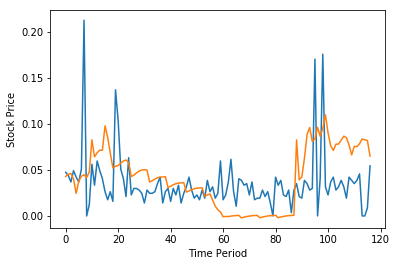

In [44]:
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
minMaxDeNormalizer(test_predict,originalSales)

In [ ]:
len(test_predict)

In [ ]:
len(testY)

In [ ]:
397*0.3

In [48]:
testY_RMSE=np.array([[i] for i in testY_RMSE])

In [45]:
testY

array([[ 0.04736842],
       [ 0.04385965],
       [ 0.03684211],
       [ 0.04912281],
       [ 0.04210526],
       [ 0.03684211],
       [ 0.05087719],
       [ 0.2122807 ],
       [ 0.        ],
       [ 0.0122807 ],
       [ 0.05614035],
       [ 0.03333333],
       [ 0.05964912],
       [ 0.04912281],
       [ 0.04035088],
       [ 0.02631579],
       [ 0.01754386],
       [ 0.02631579],
       [ 0.01578947],
       [ 0.13684211],
       [ 0.10350877],
       [ 0.05087719],
       [ 0.04035088],
       [ 0.02105263],
       [ 0.06315789],
       [ 0.02280702],
       [ 0.02982456],
       [ 0.02982456],
       [ 0.02807018],
       [ 0.0245614 ],
       [ 0.01403509],
       [ 0.02807018],
       [ 0.0245614 ],
       [ 0.0245614 ],
       [ 0.02631579],
       [ 0.03508772],
       [ 0.04210526],
       [ 0.01403509],
       [ 0.02631579],
       [ 0.02982456],
       [ 0.01578947],
       [ 0.02982456],
       [ 0.02280702],
       [ 0.03333333],
       [ 0.01403509],
       [ 0